<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#One-Hot-Encoding" data-toc-modified-id="One-Hot-Encoding-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>One-Hot Encoding</a></span></li><li><span><a href="#class_weights='balanced'" data-toc-modified-id="class_weights='balanced'-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>class_weights='balanced'</a></span></li><li><span><a href="#Upsampling" data-toc-modified-id="Upsampling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Upsampling</a></span></li><li><span><a href="#Downsampling" data-toc-modified-id="Downsampling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Downsampling</a></span></li></ul></div>

# Отток клиентов

**Customer Churn Prediction for a Bank**

**Project Overview**

Customers have been leaving a certain bank. The exodus is gradual but noticeable every month. Bank marketers have determined that retaining existing customers is cheaper than attracting new ones.

**Objective**

The task is to predict whether a customer will leave the bank in the near future. Historical data on customer behavior and contract terminations with the bank are provided for this purpose.

**Model Building**

- Develop a model to achieve the highest possible *F1 Score*. The project's success criteria require reaching an F1 Score of at least 0.59.
- Evaluate the model's performance using the *F1 Score* on the test set independently.

**Additional Evaluation**

- Additionally, measure the *AUC-ROC* metric and compare its value with the *F1 Score*.

**Data Source**

The dataset can be found at [Kaggle: Bank Customer Churn Modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling).


## Data preparation

In [42]:
# pip install phik

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
import math

from scipy import stats as st
from scipy.spatial.distance import pdist, squareform

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.impute import SimpleImputer

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split

from joblib import dump

import phik
from phik.report import plot_correlation_matrix
from phik import report

In [44]:
try:
    data = pd.read_csv('/datasets/Churn.csv')
except:
    data = pd.read_csv(r"C:\Users\olga.poletkina\OneDrive - HPP Architekten GmbH\GitHub\Practicum_Data_Science\datasets\Churn.csv")

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**There are gaps in Tenure column**

In [46]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [47]:
data.duplicated().sum()

0

In [48]:
data.columns.to_series().groupby(data.dtypes).groups

{int64: ['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited'], float64: ['Tenure', 'Balance', 'EstimatedSalary'], object: ['Surname', 'Geography', 'Gender']}

**Client Parameters Table Overview**

**Table Composition**

The table contains 14 columns with client parameters.

**Features:**

- `RowNumber` — Index of the row in the data.
- `CustomerId` — Unique identifier of the client.
- `Surname` — Last name.
- `CreditScore` — Credit rating.
- `Geography` — Country of residence.
- `Gender` — Gender.
- `Age` — Age.
- `Tenure` — Number of years the person has been a client of the bank.
- `Balance` — Account balance.
- `NumOfProducts` — Number of bank products used by the client.
- `HasCrCard` — Whether the client has a credit card.
- `IsActiveMember` — Whether the client is an active member.
- `EstimatedSalary` — Estimated salary.

**Target Feature:**

- `Exited` — Whether the client left the bank.

**Data Overview**

- The table consists of 10,000 rows. Missing values are only found in the `Tenure` column.
- No obvious duplicates were detected.
- The data types are as follows: `RowNumber`, `CustomerId`, `CreditScore`, `Age`, `NumOfProducts`, `HasCrCard`, `IsActiveMember`, `Exited` are of type `int`; `Tenure`, `Balance`, `EstimatedSalary` are of type `float`; the remaining features are of type `object` (string).

In [49]:
def add_underscore(name):
    new_name = ''
    for i, char in enumerate(name):
        if i > 0 and char.isupper() and name[i-1].islower():
            new_name += '_'
        new_name += char
    return new_name

new_columns = {col: add_underscore(col) for col in data.columns}

data = data.rename(columns=new_columns)
data.head()

,Row_Number,Customer_Id,Surname,Credit_Score,Geography,Gender,Age,Tenure,Balance,Num_Of_Products,Has_Cr_Card,Is_Active_Member,Estimated_Salary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [50]:
data.columns = data.columns.str.strip().str.lower()
data.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [51]:
data = data.drop(columns=['row_number', 'surname'])

**The row_number and surname columns have been removed, the surname is no longer necessary because client could be identified by ID, column names are following PEP8.**

In [52]:
data['geography'] = data['geography'].str.lower()
data['gender'] = data['gender'].str.lower()
print(data['geography'].unique())
print(data['gender'].unique())

['france' 'spain' 'germany']
['female' 'male']


**The remaining categorical features have been converted to lowercase**

In [53]:
print('In total, about {} % of data is missing in the tenure column'.format(data['tenure'].isna().sum() / len(data) * 100))

In total, about 9.09 % of data is missing in the tenure column


count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64


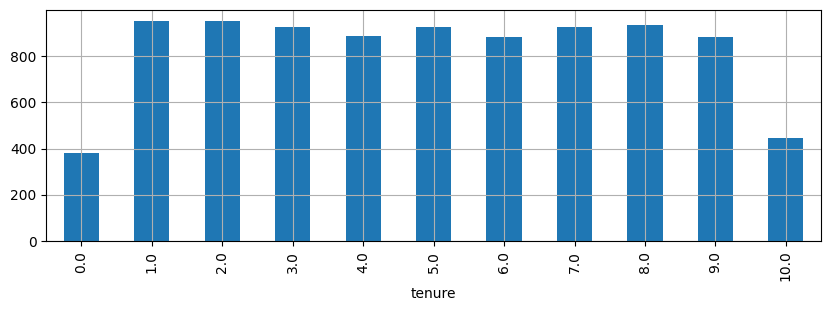

In [54]:
print(data['tenure'].describe())

data.groupby('tenure')['tenure'].count().plot(
    kind='bar', 
    grid=True,
    rot=90,
    figsize=(10, 3)
);

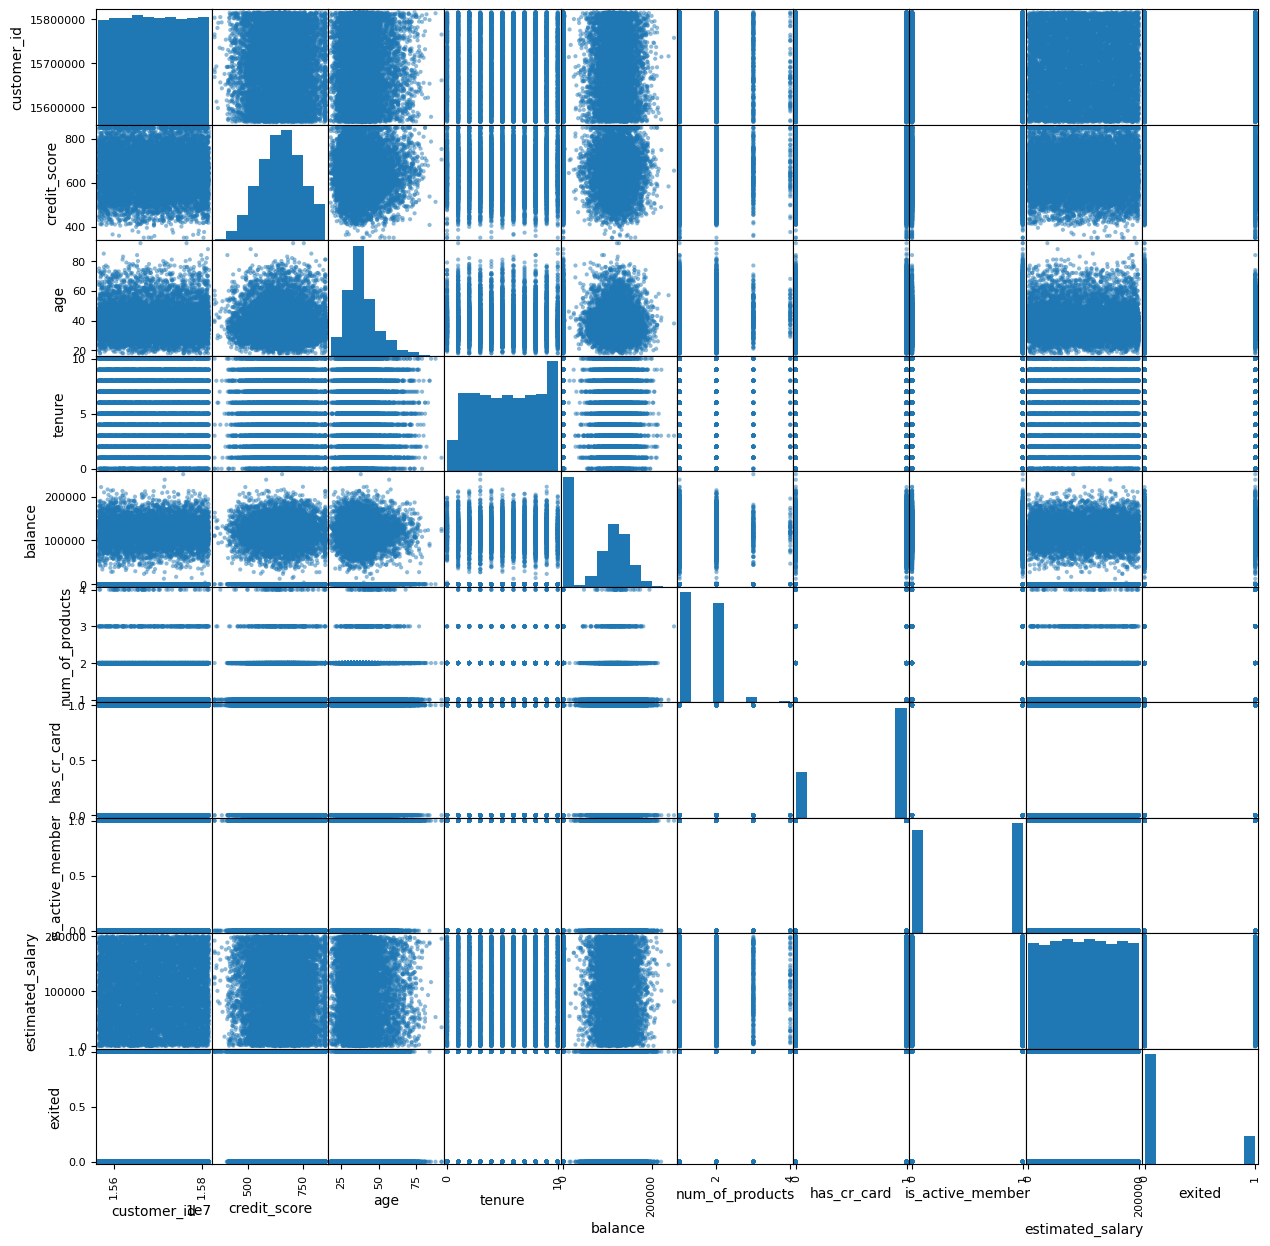

In [55]:
pd.plotting.scatter_matrix(data, figsize=(15, 15));

https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7

In [56]:
import warnings
warnings.filterwarnings('ignore')

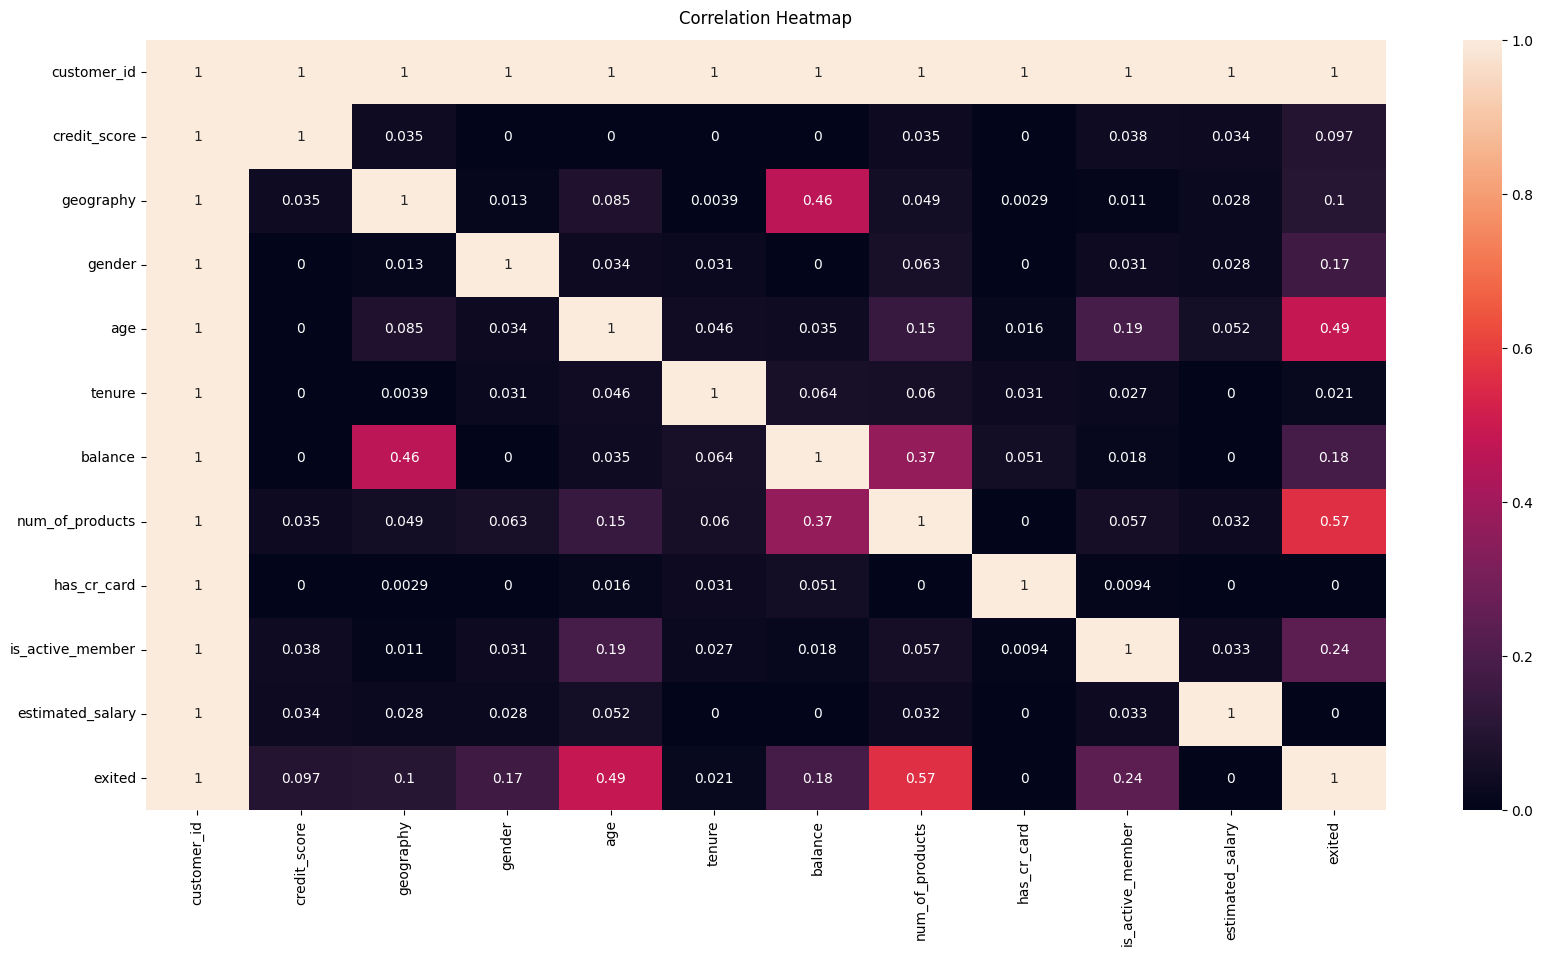

In [57]:
interval_cols = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

phik_matrix = data.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(phik_matrix, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

https://loginom.ru/blog/missing

**In total, about 9% of the data is missing in the 'tenure' column, the median value is 5, and clients who have been using the bank's services for the period from 1 to 9 years are distributed approximately evenly. Scatter_matrix does not show any correlations between this feature and others.**

**To fill in the gaps, it was decided to use median values.**

count    10000.00000
mean         4.99790
std          2.76001
min          0.00000
25%          3.00000
50%          5.00000
75%          7.00000
max         10.00000
Name: tenure, dtype: float64


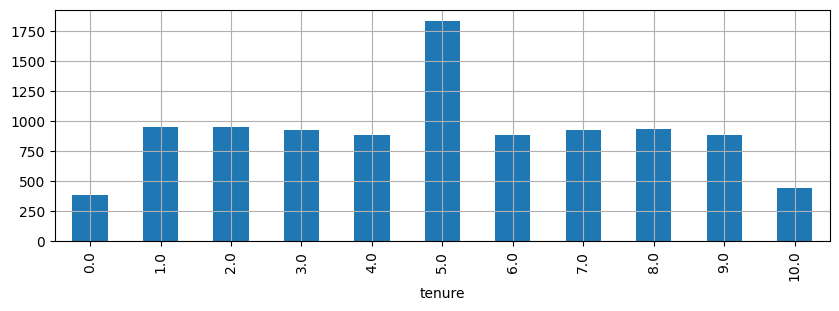

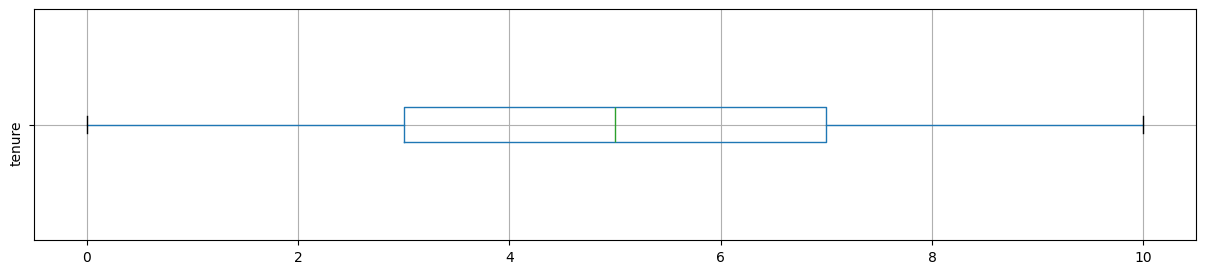

In [58]:
data['tenure'] = data['tenure'].fillna(data['tenure'].median())

print(data['tenure'].describe())

data.groupby('tenure')['tenure'].count().plot(
    kind='bar', 
    grid=True,
    rot=90,
    figsize=(10, 3)
);

plt.show()

data[['tenure']].boxplot(
    figsize=(15, 3),
    vert=False, 
    rot=90, 
    fontsize=10,
);

In [59]:
data['tenure'] = data['tenure'].astype(int)

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: balance, dtype: float64


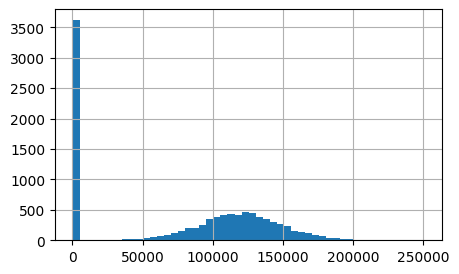

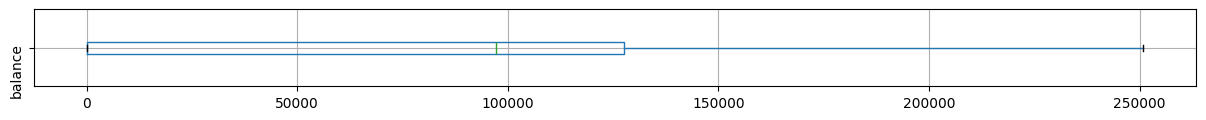

In [60]:
print(data['balance'].describe())
data['balance'].hist(
    bins=50,
    figsize=(5, 3)
);
plt.show()

data[['balance']].boxplot(
    figsize=(15, 1),
    vert=False, 
    rot=90, 
    fontsize=10,
);

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: credit_score, dtype: float64


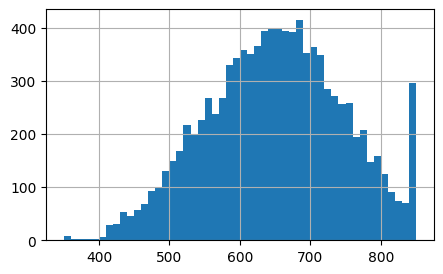

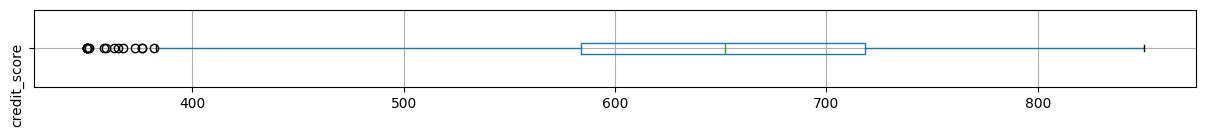

In [61]:
print(data['credit_score'].describe())

data['credit_score'].hist(
    bins=50,
    figsize=(5, 3)
);
plt.show()

data[['credit_score']].boxplot(
    figsize=(15, 1),
    vert=False, 
    rot=90, 
    fontsize=10,
);

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64


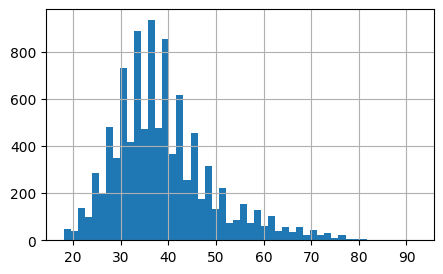

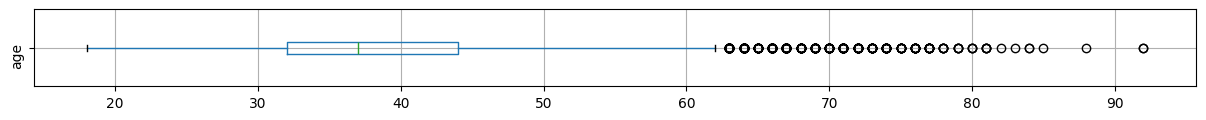

In [62]:
print(data['age'].describe())

data['age'].hist(
    bins=50,
    figsize=(5, 3)
);
plt.show()

data[['age']].boxplot(
    figsize=(15, 1),
    vert=False, 
    rot=90, 
    fontsize=10,
);

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimated_salary, dtype: float64


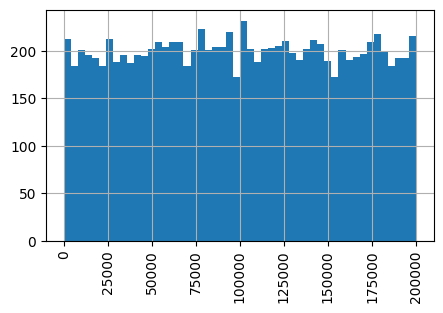

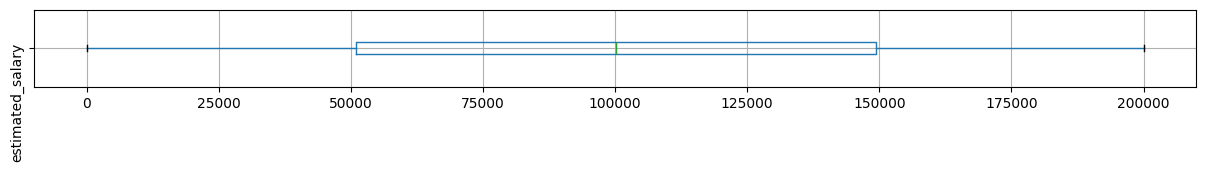

In [63]:
print(data['estimated_salary'].describe())

data['estimated_salary'].hist(
    bins=50,
    figsize=(5, 3),
);
plt.xticks(rotation=90)
plt.show()

data[['estimated_salary']].boxplot(
    figsize=(15, 1),
    vert=False, 
    rot=90, 
    fontsize=10,
);

**Observations from Scatter Matrix Analysis:**
- More than 3,500 entries have a 'balance' equal to zero, but the rest of the distribution appears normal.
- The distribution of credit score is close to normal.
- The bank's primary clients are people up to 62 years old.
- Data on estimated salary is uniformly distributed.
- Data in 'numofproducts' is binomially distributed.
- Data in 'hascrcard', 'isactivemember', 'exited' follow a Bernoulli distribution.
- No significant correlations between features in the table were identified.

## Problem research

### One-Hot Encoding

In [64]:
# %%script echo skipping

target = data['exited']
features = data.drop(['customer_id','exited'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, 
    target, 
    test_size=0.40, 
    random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, 
    target_valid, 
    test_size=0.50, 
    random_state=12345) 

print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(6000, 10)
(6000,)
(2000, 10)
(2000,)
(2000, 10)
(2000,)


In [65]:
# %%script echo skipping

warnings.filterwarnings("ignore")
# features
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
# encoder
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(features_train[ohe_features])
# transform
features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[ohe_features])
features_valid[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_valid[ohe_features])
features_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test[ohe_features])
# drop columns
features_train = features_train.drop(ohe_features, axis=1)
features_valid = features_valid.drop(ohe_features, axis=1)
features_test = features_test.drop(ohe_features, axis=1)

### Scaling using StandardScaler().

In [66]:
print(data.num_of_products.unique())
print(data.tenure.unique())

[1 3 2 4]
[ 2  1  8  7  4  6  3 10  5  9  0]


In [68]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary', 'num_of_products']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape) 
print(features_valid.shape) 
print(features_test.shape) 

(6000, 11)
(2000, 11)
(2000, 11)


In [69]:
features_train.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_germany,geography_spain,gender_male
7479,-0.886751,-0.373192,1.082277,1.232271,-0.891560,1,0,-0.187705,0.0,1.0,1.0
3411,0.608663,-0.183385,1.082277,0.600563,-0.891560,0,0,-0.333945,0.0,0.0,0.0
6027,2.052152,0.480939,-0.737696,1.027098,0.830152,0,1,1.503095,1.0,0.0,1.0
1247,-1.457915,-1.417129,0.354288,-1.233163,0.830152,1,0,-1.071061,0.0,0.0,1.0
3716,0.130961,-1.132419,-1.101690,1.140475,-0.891560,0,0,1.524268,1.0,0.0,0.0


### Checking the data balance in the 'exited' column

exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

Negative values are 4 times greater than positive values


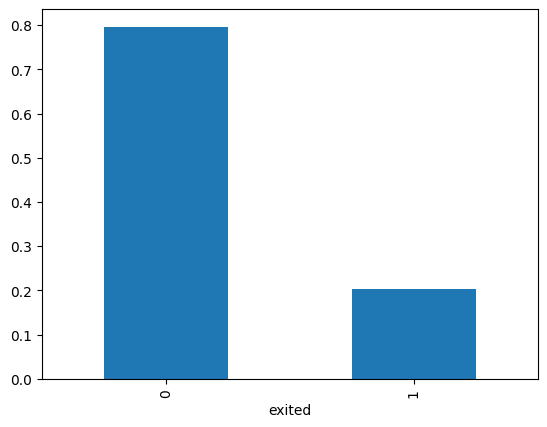

In [70]:
class_frequency = data['exited'].value_counts(normalize=True)
print(class_frequency)
print()
print('Negative values are {} times greater than positive values'.format(round(class_frequency[0]/class_frequency[1])))
class_frequency.plot(kind='bar');

**A balance check shows that positive values ​​account for about 20% of the total. There is an imbalance in the data.**

### Training unbalanced data

**DecisionTreeClassifier**

In [71]:
model_dtc = DecisionTreeClassifier(random_state=12345)
model_dtc.fit(features_train, target_train)

predicted_valid_dtc = model_dtc.predict(features_valid)
accuracy_valid_dtc = accuracy_score(target_valid, predicted_valid_dtc)

print('Accuracy:',accuracy_valid_dtc)
print('Recall:',recall_score(target_valid, predicted_valid_dtc))
print('Precision:',precision_score(target_valid, predicted_valid_dtc))
print('F1:',f1_score(target_valid, predicted_valid_dtc))
confusion_matrix(target_valid, predicted_valid_dtc)

Accuracy: 0.7865
Recall: 0.458628841607565
Precision: 0.49489795918367346
F1: 0.4760736196319018


array([[1379,  198],
       [ 229,  194]], dtype=int64)

**RandomForestClassifier**

In [72]:
model_rfc = RandomForestClassifier(random_state=12345)
model_rfc.fit(features_train, target_train)

predicted_valid_rfc = model_rfc.predict(features_valid)
accuracy_valid_rfc = accuracy_score(target_valid, predicted_valid_rfc)

print('Accuracy:',accuracy_valid_rfc)
print('Recall:',recall_score(target_valid, predicted_valid_rfc))
print('Precision:',precision_score(target_valid, predicted_valid_rfc))
print('F1:',f1_score(target_valid, predicted_valid_rfc))
confusion_matrix(target_valid, predicted_valid_rfc)

Accuracy: 0.8495
Recall: 0.4302600472813239
Precision: 0.7520661157024794
F1: 0.5473684210526315


array([[1517,   60],
       [ 241,  182]], dtype=int64)

**LogisticRegression**

In [73]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_train, target_train)

predicted_valid_lr = model_lr.predict(features_valid)
accuracy_valid_lr = accuracy_score(target_valid, predicted_valid_lr)

print('Accuracy:',accuracy_valid_lr)
print('Recall:',recall_score(target_valid, predicted_valid_lr))
print('Precision:',precision_score(target_valid, predicted_valid_lr))
print('F1:',f1_score(target_valid, predicted_valid_lr))
confusion_matrix(target_valid, predicted_valid_lr)

Accuracy: 0.7915
Recall: 0.1867612293144208
Precision: 0.5197368421052632
F1: 0.27478260869565213


array([[1504,   73],
       [ 344,   79]], dtype=int64)

Area Under Curve ROC_dtc: 0.666536995312343
Area Under Curve ROC_rfc: 0.8499762394107974
Area Under Curve ROC_lr: 0.7386410142248726


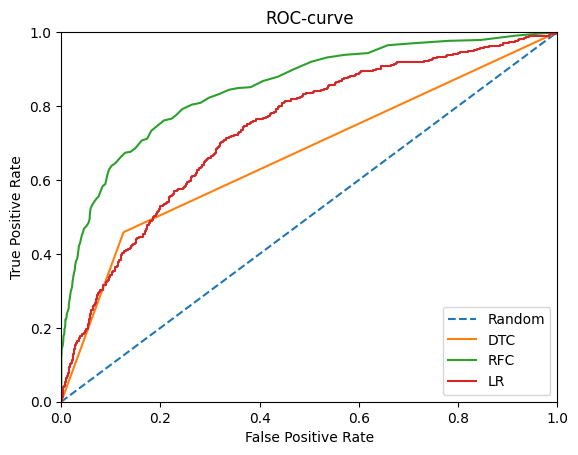

In [74]:
probabilities_valid_dtc = model_dtc.predict_proba(features_valid)
# print(probabilities_valid_dtc)
probabilities_one_valid_dtc = probabilities_valid_dtc[:, 1]

probabilities_valid_rfc = model_rfc.predict_proba(features_valid)
probabilities_one_valid_rfc = probabilities_valid_rfc[:, 1]

probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

fpr_dtc, tpr_dtc, thresholds = roc_curve(target_valid, probabilities_one_valid_dtc) 
fpr_rfc, tpr_rfc, thresholds = roc_curve(target_valid, probabilities_one_valid_rfc) 
fpr_lr, tpr_lr, thresholds = roc_curve(target_valid, probabilities_one_valid_lr)

print('Area Under Curve ROC_dtc:', roc_auc_score(target_valid, probabilities_one_valid_dtc))
print('Area Under Curve ROC_rfc:', roc_auc_score(target_valid, probabilities_one_valid_rfc))
print('Area Under Curve ROC_lr:', roc_auc_score(target_valid, probabilities_one_valid_lr))

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr_dtc, tpr_dtc)
plt.plot(fpr_rfc, tpr_rfc)
plt.plot(fpr_lr, tpr_lr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(['Random', 'DTC', 'RFC', 'LR'])
plt.show() 

**Training DecisionTreeClassifier, RandomForestClassifier, and LogisticRegression on imbalanced data yielded the following results:**
- The confusion matrices of all three models show a significant number of errors in the FN (False Negative) and FP (False Positive) quadrants.
- Recall, the proportion of TP responses among values with a true label of 1, is around 0.45-0.43 for DecisionTreeClassifier and RandomForestClassifier, while LogisticRegression shows a much lower value of 0.18.
- The precision of RandomForestClassifier is 0.75, higher than the other two models.
- In all models, the F1 score is below the required level of 0.59.

## Working with imbalance

### class_weights='balanced'

**DecisionTreeClassifier**

In [75]:
criterions = ['gini', 'entropy', 'log_loss']

best_model_dtc = None
best_f1_dtc = 0

for min_samples_split in range(2, 10):
    for depth in range(1, 10):
        for criterion in criterions:
            try:
                model_dtc = DecisionTreeClassifier(random_state=12345, min_samples_split=min_samples_split, 
                                               max_depth=depth, criterion=criterion, class_weight='balanced')
                model_dtc.fit(features_train, target_train)
    
                predictions_valid_dtc = model_dtc.predict(features_valid)
                f1_dtc = f1_score(target_valid, predictions_valid_dtc)
                if f1_dtc > best_f1_dtc:
                    best_f1_dtc = f1_dtc
                    best_model_dtc = model_dtc
            except:
                pass

print('The F1 score of the best model:', best_f1_dtc)
print('model:', best_model_dtc)

F1 best model : 0.5809128630705395
model: DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345)


**RandomForestClassifier**

In [76]:
max_features = [['sqrt', 'log2', None], [n for n in range(1, 6)]]
max_features = sum(max_features, [])

best_model_rfc = None
best_f1_rfc = 0

for max_depth in range(1, 16, 2):
    for est in range(1, 120, 20):
        for max_feature in max_features:
            for criterion in criterions:
                try:
                    model_rfc = RandomForestClassifier(random_state=12345, n_estimators=est, 
                                max_depth=max_depth, criterion=criterion, max_features=max_feature, class_weight='balanced') 
                    model_rfc.fit(features_train, target_train)

                    predictions_valid_rfc = model_rfc.predict(features_valid)
                    f1_rfc = f1_score(target_valid, predictions_valid_rfc)
                    if f1_rfc > best_f1_rfc:
                        best_f1_rfc = f1_rfc
                        best_model_rfc = model_rfc 
                except:
                    pass

print('The F1 score of the best model:', best_f1_rfc)
print('model:', best_model_rfc)

F1 best model : 0.6275720164609054
model: RandomForestClassifier(class_weight='balanced', max_depth=7, max_features=5,
                       n_estimators=101, random_state=12345)


**LogisticRegression**

In [77]:
warnings.filterwarnings("ignore")

solvers = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
penalties = ['l1', 'l2']

best_model_lr = None
best_f1_lr = 0

for solver in solvers:
    for penalty in penalties:
        for max_iter in range(500, 5000, 500):
            try:
                model_lr = LogisticRegression(penalty=penalty, random_state=12345, solver=solver, 
                                              max_iter=1000, class_weight='balanced')
                model_lr.fit(features_train, target_train) 

                predictions_valid_lr = model_lr.predict(features_valid)
                f1_lr = f1_score(target_valid, predicted_valid_lr)
        
                if f1_lr > best_f1_lr:
                    best_f1_lr = f1_lr
                    best_model_lr = model_lr
            except:
                pass

print('The F1 score of the best model:', best_f1_lr)
print('model:', best_model_lr)

The F1 score of the best model: 0.27478260869565213
model: LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=12345, solver='liblinear')


Area Under Curve ROC_dtc: 0.8355347481752318
Area Under Curve ROC_rfc: 0.8621121289937652
Area Under Curve ROC_lr: 0.7419135294443919


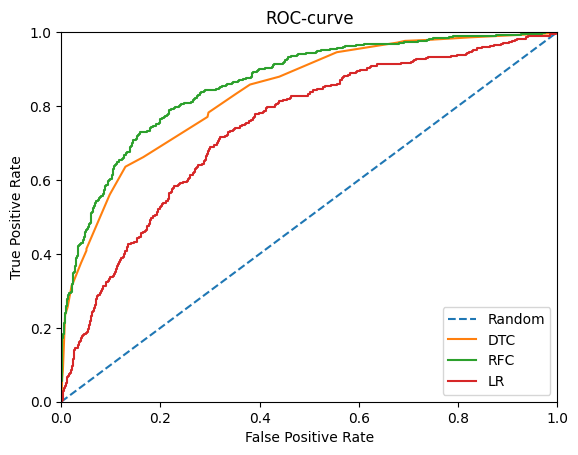

In [78]:
model_dtc = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345)
model_dtc.fit(features_train, target_train)
probabilities_valid_dtc = model_dtc.predict_proba(features_valid)
probabilities_one_valid_dtc = probabilities_valid_dtc[:, 1]

model_rfc = RandomForestClassifier(class_weight='balanced', max_depth=7, max_features=5,
                       n_estimators=101, random_state=12345)
model_rfc.fit(features_train, target_train)
probabilities_valid_rfc = model_rfc.predict_proba(features_valid)
probabilities_one_valid_rfc = probabilities_valid_rfc[:, 1]

model_lr = LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1', random_state=12345, solver='liblinear')
model_lr.fit(features_train, target_train) 
probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

fpr_dtc, tpr_dtc, thresholds = roc_curve(target_valid, probabilities_one_valid_dtc) 
fpr_rfc, tpr_rfc, thresholds = roc_curve(target_valid, probabilities_one_valid_rfc) 
fpr_lr, tpr_lr, thresholds = roc_curve(target_valid, probabilities_one_valid_lr)

print('Area Under Curve ROC_dtc:', roc_auc_score(target_valid, probabilities_one_valid_dtc))
print('Area Under Curve ROC_rfc:', roc_auc_score(target_valid, probabilities_one_valid_rfc))
print('Area Under Curve ROC_lr:', roc_auc_score(target_valid, probabilities_one_valid_lr))

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr_dtc, tpr_dtc)
plt.plot(fpr_rfc, tpr_rfc)
plt.plot(fpr_lr, tpr_lr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(['Random', 'DTC', 'RFC', 'LR'])
plt.show() 

### Upsampling

In [80]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

**Checking the balance**

exited
0    0.501043
1    0.498957
Name: proportion, dtype: float64

Negative values are 1 times greater than positive values


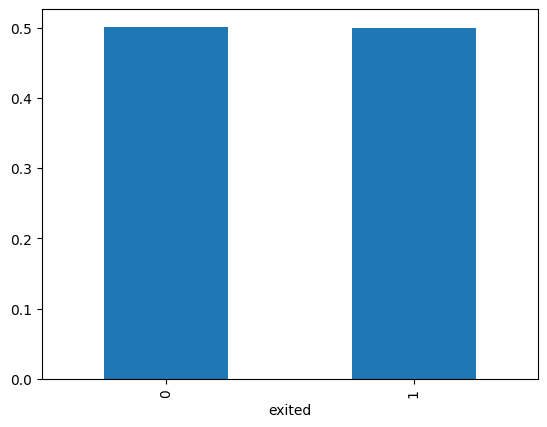

In [81]:
class_frequency = target_upsampled.value_counts(normalize=True)
print(class_frequency)
print()
print('Negative values are {} times greater than positive values'.format(round(class_frequency[0]/class_frequency[1])))
class_frequency.plot(kind='bar');

**Balance achieved**

**Testing different models with a larger sample**

**DecisionTreeClassifier**

In [82]:
criterions = ['gini', 'entropy', 'log_loss']

best_model_dtc = None
best_f1_dtc = 0

for min_samples_split in range(2, 10):
    for depth in range(1, 10):
        for criterion in criterions:
            try:
                model_dtc = DecisionTreeClassifier(random_state=12345, min_samples_split=min_samples_split, 
                                               max_depth=depth, criterion=criterion)
                model_dtc.fit(features_upsampled, target_upsampled)
    
                predictions_valid_dtc = model_dtc.predict(features_valid)
                f1_dtc = f1_score(target_valid, predictions_valid_dtc)
                       
                if f1_dtc > best_f1_dtc:
                    best_f1_dtc = f1_dtc
                    best_model_dtc = model_dtc
            except:
                pass

print('The F1 score of the best model:', best_f1_dtc)
print('model:', best_model_dtc)

The F1 score of the best model: 0.5809128630705395
model: DecisionTreeClassifier(max_depth=5, random_state=12345)


**RandomForestClassifier**

In [84]:
max_features = [['sqrt', 'log2', None], [n for n in range(1, 6)]]
max_features = sum(max_features, [])

# criterions = ['gini', 'entropy', 'log_loss']

best_model_rfc = None
best_f1_rfc = 0

for max_depth in range(1, 16, 2):
    for est in range(1, 120, 20):
        for max_feature in max_features:
            for criterion in criterions:
                try:
                    model_rfc = RandomForestClassifier(random_state=12345, n_estimators=est, 
                                                   max_depth=max_depth, criterion=criterion, max_features=max_feature) 
                    model_rfc.fit(features_upsampled, target_upsampled)

                    predictions_valid_rfc = model_rfc.predict(features_valid)
                    f1_rfc = f1_score(target_valid, predictions_valid_rfc)
                    if f1_rfc > best_f1_rfc:
                        best_f1_rfc = f1_rfc
                        best_model_rfc = model_rfc 
                except:
                    pass

print('The F1 score of the best model:', best_f1_rfc)
print('model:', best_model_rfc)

The F1 score of the best model: 0.6266804550155118
model: RandomForestClassifier(criterion='entropy', max_depth=9, max_features=4,
                       n_estimators=81, random_state=12345)


**LogisticRegression**

In [85]:
warnings.filterwarnings("ignore")

solvers = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
penalties = ['l1', 'l2']

best_model_lr = None
best_f1_lr = 0

for solver in solvers:
    for penalty in penalties:
        for max_iter in range(500, 5000, 500):
            try:
                model_lr = LogisticRegression(penalty=penalty, random_state=12345, solver=solver, max_iter=1000)
                model_lr.fit(features_upsampled, target_upsampled) 

                predictions_valid_lr = model_lr.predict(features_valid)
                f1_lr = f1_score(target_valid, predicted_valid_lr)
        
                if f1_lr > best_f1_lr:
                    best_f1_lr = f1_lr
                    best_model_lr = model_lr
            except:
                pass

print('The F1 score of the best model:', best_f1_lr)
print('model:', best_model_lr)

The F1 score of the best model: 0.27478260869565213
model: LogisticRegression(max_iter=1000, penalty='l1', random_state=12345,
                   solver='liblinear')


Area Under Curve ROC_dtc: 0.8355347481752318
Area Under Curve ROC_rfc: 0.8582010010928371
Area Under Curve ROC_lr: 0.7418445712675261


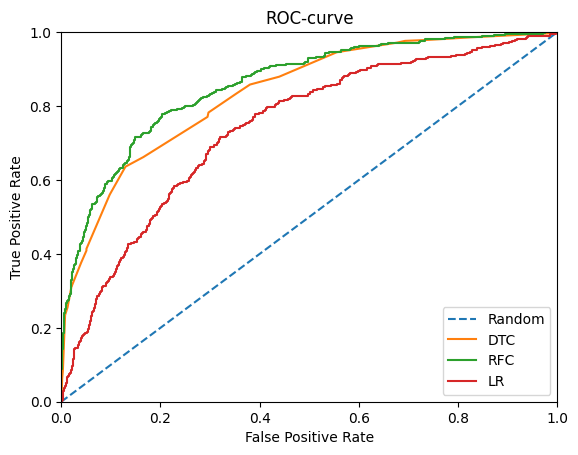

In [86]:
model_dtc = DecisionTreeClassifier(max_depth=5, random_state=12345)
model_dtc.fit(features_upsampled, target_upsampled)
probabilities_valid_dtc = model_dtc.predict_proba(features_valid)
probabilities_one_valid_dtc = probabilities_valid_dtc[:, 1]

model_rfc = RandomForestClassifier(criterion='entropy', max_depth=9, max_features=4, n_estimators=81, random_state=12345)
model_rfc.fit(features_upsampled, target_upsampled)
probabilities_valid_rfc = model_rfc.predict_proba(features_valid)
probabilities_one_valid_rfc = probabilities_valid_rfc[:, 1]

model_lr = LogisticRegression(max_iter=1000, penalty='l1', random_state=12345,solver='liblinear')
model_lr.fit(features_upsampled, target_upsampled) 
probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

fpr_dtc, tpr_dtc, thresholds = roc_curve(target_valid, probabilities_one_valid_dtc) 
fpr_rfc, tpr_rfc, thresholds = roc_curve(target_valid, probabilities_one_valid_rfc) 
fpr_lr, tpr_lr, thresholds = roc_curve(target_valid, probabilities_one_valid_lr)

print('Area Under Curve ROC_dtc:', roc_auc_score(target_valid, probabilities_one_valid_dtc))
print('Area Under Curve ROC_rfc:', roc_auc_score(target_valid, probabilities_one_valid_rfc))
print('Area Under Curve ROC_lr:', roc_auc_score(target_valid, probabilities_one_valid_lr))

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr_dtc, tpr_dtc)
plt.plot(fpr_rfc, tpr_rfc)
plt.plot(fpr_lr, tpr_lr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(['Random', 'DTC', 'RFC', 'LR'])
plt.show() 

### Downsampling

In [87]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

**Checking the balance**

exited
0    0.501043
1    0.498957
Name: proportion, dtype: float64

Negative values are 1 times greater than positive values


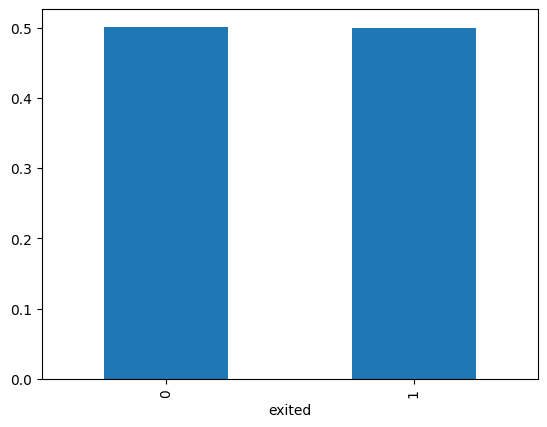

In [88]:
class_frequency = target_downsampled.value_counts(normalize=True)
print(class_frequency)
print()
print('Negative values are {} times greater than positive values'.format(round(class_frequency[0]/class_frequency[1])))
class_frequency.plot(kind='bar');

**Testing different models with a reduced sample**

**DecisionTreeClassifier**

In [89]:
criterions = ['gini', 'entropy', 'log_loss']

best_model_dtc = None
best_f1_dtc = 0

for min_samples_split in range(2, 10):
    for depth in range(1, 10):
        for criterion in criterions:
            try:
                model_dtc = DecisionTreeClassifier(random_state=12345, min_samples_split=min_samples_split, 
                                               max_depth=depth, criterion=criterion)
                model_dtc.fit(features_downsampled, target_downsampled)
    
                predictions_valid_dtc = model_dtc.predict(features_valid)
                f1_dtc = f1_score(target_valid, predictions_valid_dtc)
                       
                if f1_dtc > best_f1_dtc:
                    best_f1_dtc = f1_dtc
                    best_model_dtc = model_dtc
            except:
                pass

print('The F1 score of the best model:', best_f1_dtc)
print('model:', best_model_dtc)

The F1 score of the best model: 0.608695652173913
model: DecisionTreeClassifier(max_depth=5, min_samples_split=3, random_state=12345)


**RandomForestClassifier**

In [90]:
max_features = [['sqrt', 'log2', None], [n for n in range(1, 6)]]
max_features = sum(max_features, [])

# criterions = ['gini', 'entropy', 'log_loss']

best_model_rfc = None
best_f1_rfc = 0

for max_depth in range(1, 16, 2):
    for est in range(1, 120, 20):
        for max_feature in max_features:
            for criterion in criterions:
                try:
                    model_rfc = RandomForestClassifier(random_state=12345, n_estimators=est, 
                                                   max_depth=max_depth, criterion=criterion, max_features=max_feature) 
                    model_rfc.fit(features_downsampled, target_downsampled)

                    predictions_valid_rfc = model_rfc.predict(features_valid)
                    f1_rfc = f1_score(target_valid, predictions_valid_rfc)
                    if f1_rfc > best_f1_rfc:
                        best_f1_rfc = f1_rfc
                        best_model_rfc = model_rfc 
                except:
                    pass

print('The F1 score of the best model:', best_f1_rfc)
print('model:', best_model_rfc)

The F1 score of the best model: 0.5998125585754451
model: RandomForestClassifier(max_depth=7, max_features=4, n_estimators=81,
                       random_state=12345)


**LogisticRegression**

In [ ]:
warnings.filterwarnings("ignore")

solvers = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
penalties = ['l1', 'l2']

best_model_lr = None
best_f1_lr = 0

for solver in solvers:
    for penalty in penalties:
        for max_iter in range(500, 5000, 500):
            try:
                model_lr = LogisticRegression(penalty=penalty, random_state=12345, solver=solver, max_iter=1000)
                model_lr.fit(features_downsampled, target_downsampled) 

                predictions_valid_lr = model_lr.predict(features_valid)
                f1_lr = f1_score(target_valid, predicted_valid_lr)
        
                if f1_lr > best_f1_lr:
                    best_f1_lr = f1_lr
                    best_model_lr = model_lr
            except:
                pass

print('The F1 score of the best model:', best_f1_lr)
print('model:', best_model_lr)

In [ ]:
model_dtc = DecisionTreeClassifier(max_depth=5, min_samples_split=3, random_state=12345)
model_dtc.fit(features_downsampled, target_downsampled)
probabilities_valid_dtc = model_dtc.predict_proba(features_valid)
probabilities_one_valid_dtc = probabilities_valid_dtc[:, 1]

model_rfc = RandomForestClassifier(max_depth=7, max_features=4, n_estimators=81,random_state=12345)
model_rfc.fit(features_downsampled, target_downsampled)
probabilities_valid_rfc = model_rfc.predict_proba(features_valid)
probabilities_one_valid_rfc = probabilities_valid_rfc[:, 1]

model_lr = LogisticRegression(max_iter=1000, penalty='l1', random_state=12345, solver='liblinear')
model_lr.fit(features_downsampled, target_downsampled)
probabilities_valid_lr = model_lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]

fpr_dtc, tpr_dtc, thresholds = roc_curve(target_valid, probabilities_one_valid_dtc) 
fpr_rfc, tpr_rfc, thresholds = roc_curve(target_valid, probabilities_one_valid_rfc) 
fpr_lr, tpr_lr, thresholds = roc_curve(target_valid, probabilities_one_valid_lr)

print('Area Under Curve ROC_dtc:', roc_auc_score(target_valid, probabilities_one_valid_dtc))
print('Area Under Curve ROC_rfc:', roc_auc_score(target_valid, probabilities_one_valid_rfc))
print('Area Under Curve ROC_lr:', roc_auc_score(target_valid, probabilities_one_valid_lr))

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr_dtc, tpr_dtc)
plt.plot(fpr_rfc, tpr_rfc)
plt.plot(fpr_lr, tpr_lr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.legend(['Random', 'DTC', 'RFC', 'LR'])
plt.show() 

**Following the balancing of the models, the following conclusions were drawn:**
- All three approaches – adjusting class weight balance, upsampling, and downsampling – improved the performance of the models and resulted in higher F1 scores.
- Downsampling proved effective for DecisionTreeClassifier, while class weight adjustment and upsampling were most effective in the RandomForestClassifier model.
- The ROC curve and the area under the curve (AUC) for RandomForestClassifier showed the highest results.
- As the F1 score increases, the area under the ROC curve also increases.

### Choosing the best model

**Following the balancing of the models, the best results were shown by RandomForestClassifier with `class_weight='balanced'`, RandomForestClassifier with Upsampling, and DecisionTreeClassifier with Downsampling. We select the second model for testing on the test dataset.**

In [ ]:
model_rfc_cw = RandomForestClassifier(class_weight='balanced', max_depth=7, max_features=5, n_estimators=101, random_state=12345)
model_rfc_cw.fit(features_upsampled, target_upsampled)
predictions_valid_rfc_cw = model_rfc_cw.predict(features_valid)
f1_rfc = f1_score(target_valid, predictions_valid_rfc_cw)
f1_rfc

In [ ]:
model_rfc_up = RandomForestClassifier(criterion='entropy', max_depth=9, max_features=4, n_estimators=81, random_state=12345)
model_rfc_up.fit(features_upsampled, target_upsampled)
predictions_valid_rfc_up = model_rfc_up.predict(features_valid)
f1_rfc = f1_score(target_valid, predictions_valid_rfc_up)
f1_rfc

In [ ]:
model_dtc_down = DecisionTreeClassifier(max_depth=5, min_samples_split=3, random_state=12345)
model_dtc_down.fit(features_downsampled, target_downsampled)
predictions_valid_dtc_down = model_dtc_down.predict(features_valid)
f1_rfc = f1_score(target_valid, predictions_valid_dtc_down)
f1_rfc

## Model testing

In [ ]:
final_model = model_rfc_up
final_model.fit(features_upsampled, target_upsampled)
predictions_test = final_model.predict(features_test)

f1_test = f1_score(target_test, predictions_test)
accuracy_test = accuracy_score(target_test, predictions_test)
recall = recall_score(target_test, predictions_test)
precision = precision_score(target_test, predictions_test)

print('F1 on test sample :', f1_test)
print()
print('Accuracy on test sample :', accuracy_test)
print('Recall on test sample :',recall)
print('Precision on test sample :', precision)

confusion_matrix(target_test, predictions_test)

In [ ]:
probabilities_test = final_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

print('Area Under Curve ROC_final:', roc_auc_score(target_test, probabilities_one_test))

plt.figure()

plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr, tpr)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show() 

**As a result of the research, the RandomForestClassifier model (with parameters `criterion='entropy'`, `max_depth=9`, `max_features=4`, `n_estimators=81`, `random_state=12345`) was selected. It achieved an F1 score of 0.62 on the test set, satisfying the project's objective. The area under the ROC curve is approximately 0.86, and the model's accuracy on the test set is 0.821.**

## Conclusion

**In the project, an analysis of the bank's client characteristics table was conducted, and a model was chosen that demonstrated an `F1` score higher than 0.59.**

**Following the data analysis, the following conclusions and changes were made:**
- No obvious duplicates were found.
- Column names were corrected to lowercase with underscores.
- Columns `row_number` and `surname` were removed, as the surname is not necessary for identifying clients who can be identified by ID.
- Remaining categorical features were converted to lowercase.
- Missing values were found in the `tenure` column, accounting for about 9% of the data, with a median value of 5; customers using the bank's services for 1 to 9 years are approximately evenly distributed. No correlations of this feature with others were observed on the scatter matrix.
- To fill in the missing values, it was decided to use median values.
- More than 3,500 people have a `balance` equal to zero; otherwise, the distribution appears normal.
- The distribution of credit scores is close to normal.
- The bank's main clients are people up to 62 years old.
- Data on estimated salary are evenly distributed.
- Data in `numofproducts` is binomially distributed.
- Data in `hascrcard`, `isactivemember`, `exited` follow a Bernoulli distribution.
- No significant correlations of features in the table were detected.

**For the classification task, the data processing technique One-Hot Encoding was chosen. The data were split into three samples - train, valid, test - and then processed using `OneHotEncoder`. The data were then scaled using `StandardScaler()`.**

**The balance in the 'exited' column was then checked. The check shows that positive values make up about 20% of the total number. There is an imbalance in the data.**

**Next, the classification models `DecisionTreeClassifier`, `RandomForestClassifier`, and `LogisticRegression` were trained on unbalanced data, yielding the following results:**
- Confusion matrices of all three models show a significant number of errors in the `FN` (False Negative) and `FP` (False Positive) quadrants.
- Recall, the proportion of `TP` responses among values with a true label of 1, in `DecisionTreeClassifier` and `RandomForestClassifier` is around 0.45-0.43, while `LogisticRegression` shows a very low value of 0.18.
- The precision of `RandomForestClassifier` is 0.75, while the other two models show a lower score.
- In all models, the harmonic mean score is below the required level of 0.59.

**The data were then balanced using three methods:**
- Adding balance to class weight.
- Upsampling.
- Downsampling.

**The following conclusions were drawn as a result:**
- All three approaches - adding balance to class weight, upsampling, and downsampling - improved the performance of the models and showed a higher F1 score.
- Downsampling was effective for `DecisionTreeClassifier`, while adding balance and upsampling were most effective in the `RandomForestClassifier` model.
- The ROC curve and area under the curve for `RandomForestClassifier` showed the highest result.
- As the F1 score increases, the area under the ROC curve also increases.

**Following the balancing of the models, the best result was shown by `RandomForestClassifier` with `class_weight='balanced'`, `RandomForestClassifier` with Upsampling, and `DecisionTreeClassifier` with Downsampling. We choose the second model for testing on the test sample.**

**As a result of the research, the `RandomForestClassifier` model (criterion='entropy', max_depth=9, max_features=4, n_estimators=81, random_state=12345) was selected. It achieved an `F1` score of 0.62 on the test set, satisfying the project's objective. The area under the `ROC` curve is approximately 0.86, and the model's accuracy on the test set is 0.821.**